# Data Normalization: *Part 2*
#### **Skew Transformation**

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import zscore
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data = pd.read_csv('GHG_Post_Outlier.csv')

# create dataframe
data['Scope_3_emissions_amount'] = pd.to_numeric(data['Scope_3_emissions_amount'], errors='coerce')
# remove nulls
data = data.dropna(subset=['Scope_3_emissions_amount', 'account_name'])
# remove scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)  

data

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,country_ghg_avg,country_population_avg,country_gdp_avg
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Purchased goods and services,17.62,428.77,67346924.78,3038320070320.49
1,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Fuel-and-energy-related activities (not includ...,61.42,428.77,67346924.78,3038320070320.49
2,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Waste generated in operations,57.21,428.77,67346924.78,3038320070320.49
3,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Business travel,2549.33,428.77,67346924.78,3038320070320.49
4,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,11075670000.00,1031240000.00,8544560000.00,730250000.00,10044430000.00,Employee commuting,3.90,428.77,67346924.78,3038320070320.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44074,Slovenska Grafia,56212,2023,Slovakia,Printing services,Print & publishing services,NaN,Third-party verification or assurance process ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Waste generated in operations,341.12,37.36,5445037.30,114423893990.06
44075,Slovenska Grafia,56212,2023,Slovakia,Printing services,Print & publishing services,NaN,Third-party verification or assurance process ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Business travel,1.94,37.36,5445037.30,114423893990.06
44076,Slovenska Grafia,56212,2023,Slovakia,Printing services,Print & publishing services,NaN,Third-party verification or assurance process ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Employee commuting,682.29,37.36,5445037.30,114423893990.06
44077,Slovenska Grafia,56212,2023,Slovakia,Printing services,Print & publishing services,NaN,Third-party verification or assurance process ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Downstream transportation and distribution,1630.77,37.36,5445037.30,114423893990.06


## EDA and Normalization: Skewness and Transformation

**Analyzing Positive/Right Skew**:
   - Skewness > 0
   - Long tail extends to the right
   - Most values cluster on the left
   - Mean > Median
   - When skewness is > 1, the data is highly skewed

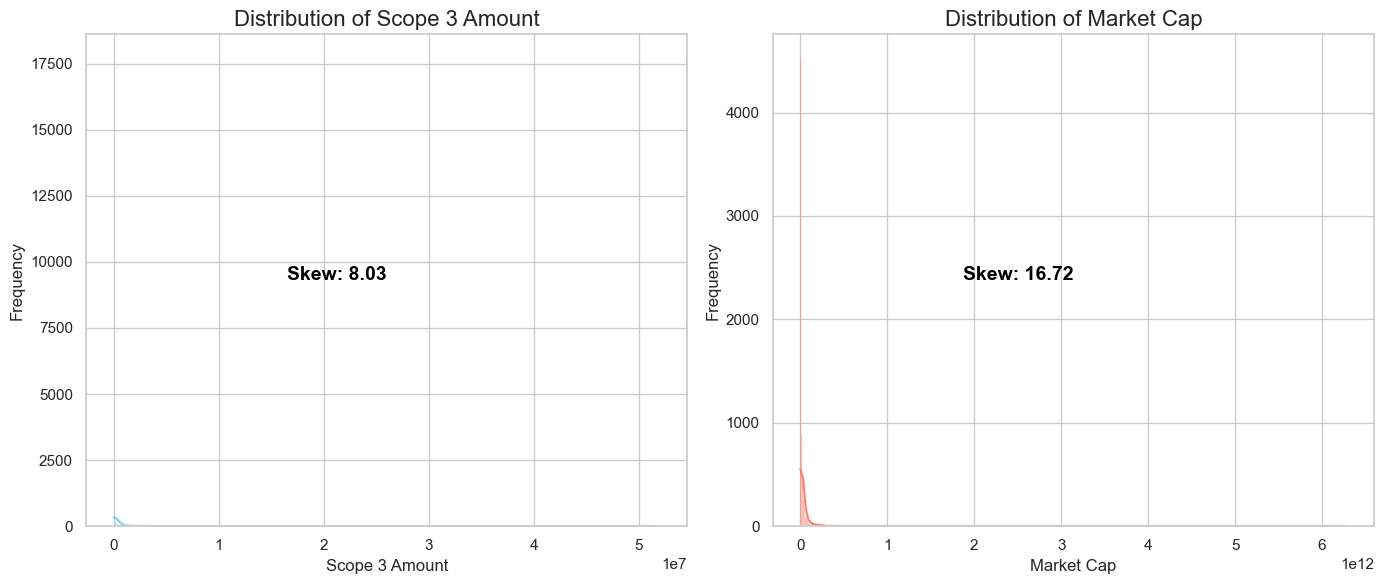

In [18]:
# looking at skewness for Scope 3 emissions amount and Market Cap
# source: https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists/

# Calculate skewness
amount_skew = data['Scope_3_emissions_amount'].skew()
market_skew = data['Market_Cap_USD'].skew()

# Set the style of seaborn
sns.set(style='whitegrid')

# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Scope 3 amount
sns.histplot(data['Scope_3_emissions_amount'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Scope 3 Amount', fontsize=16)
ax[0].set_xlabel('Scope 3 Amount')
ax[0].set_ylabel('Frequency')

# Annotate Skewness
ax[0].text(0.5, 0.5, f'Skew: {amount_skew:.2f}', transform=ax[0].transAxes,
           horizontalalignment='right', color='black', weight='bold',
           fontsize=14)

# Plot for Market Cap
sns.histplot(data['Market_Cap_USD'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of Market Cap', fontsize=16)
ax[1].set_xlabel('Market Cap')
ax[1].set_ylabel('Frequency')

# Annotate Skewness
ax[1].text(0.5, 0.5, f'Skew: {market_skew:.2f}', transform=ax[1].transAxes,
           horizontalalignment='right', color='black', weight='bold',
           fontsize=14)

plt.tight_layout()
plt.show()

Based on the outlier analysis, it is not surprising the skew on Scope 3 Emissions remains vastly high. It is also not surprising the skew on Market Cap is even more significant because this was not normalized in the previous process and the data includes companies of all sizes and revenues. I want to test different transformations to see how they perform against the original data in machine learning models.

### Applying Transformations

The main transformers that work best with the type of skewness and outlier considerations include:

**Quantile Transformer**
  - Best for non-normal distributions where data is heavily skewed
  - Robust to outliers and reduces the impact of extreme values
  - Uses quantiles information and maps data to either a uniform or normal distribution
  - Disadvantge: loses absolute value relationships

**Box Cox**
 - Makes non-normal data more normal-like, reduces skewness, stabilizes variance
 - Helps meet assumptions for many statistical tests by assuming linear model assumptions
 - Disadvantage: Only works with positive values and cannot handle zeros
    
**RobustScaler**
   - Based on IQR, uses statistics that are robust to outliers, but does not change the skew or distribution
   - Best for data with outliers or when a StandardScaler is affected by outliers and when normal distribution is not required

In [22]:
# create a copy of the dataframe
df = data.copy()

# Calculate statistics for original data
original_skew = stats.skew(df['Scope_3_emissions_amount'])
original_kurtosis = stats.kurtosis(df['Scope_3_emissions_amount'])
shapiro_test = stats.shapiro(df['Scope_3_emissions_amount'])

print("\nOriginal Data Statistics:")
print(f"Skewness: {original_skew:.3f}")
print(f"Kurtosis: {original_kurtosis:.3f}")
print(f"Shapiro-Wilk test (normality): statistic={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3e}")


Original Data Statistics:
Skewness: 8.026
Kurtosis: 77.535
Shapiro-Wilk test (normality): statistic=0.228, p-value=0.000e+00


/Users/julieanne/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Quantile Transformation (*Normal Distribution*)

/Users/julieanne/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


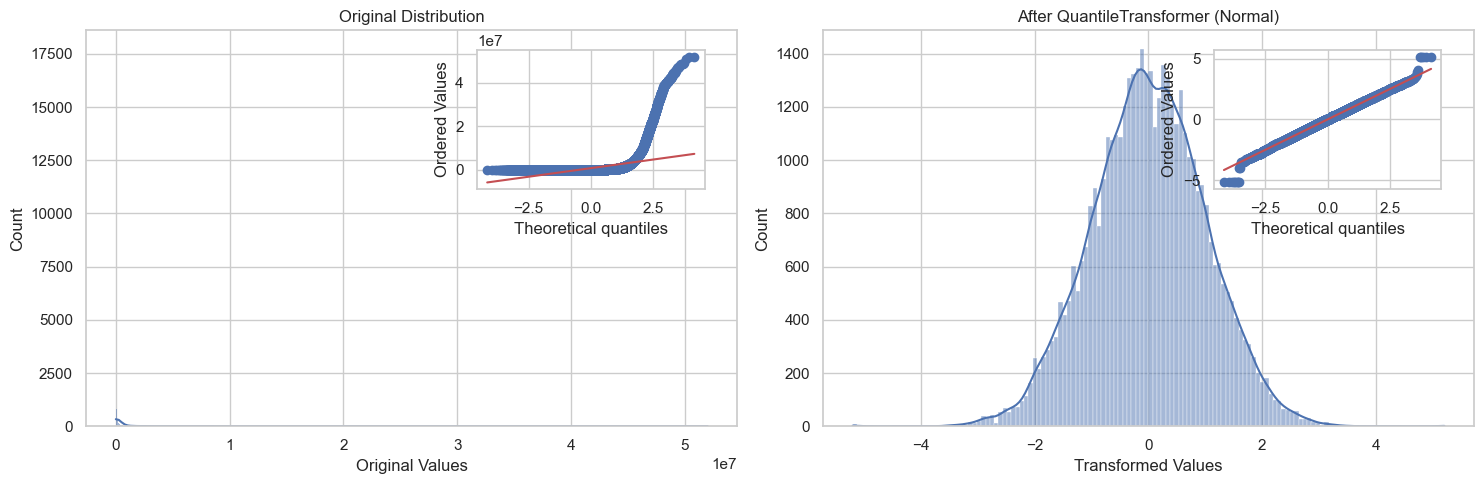

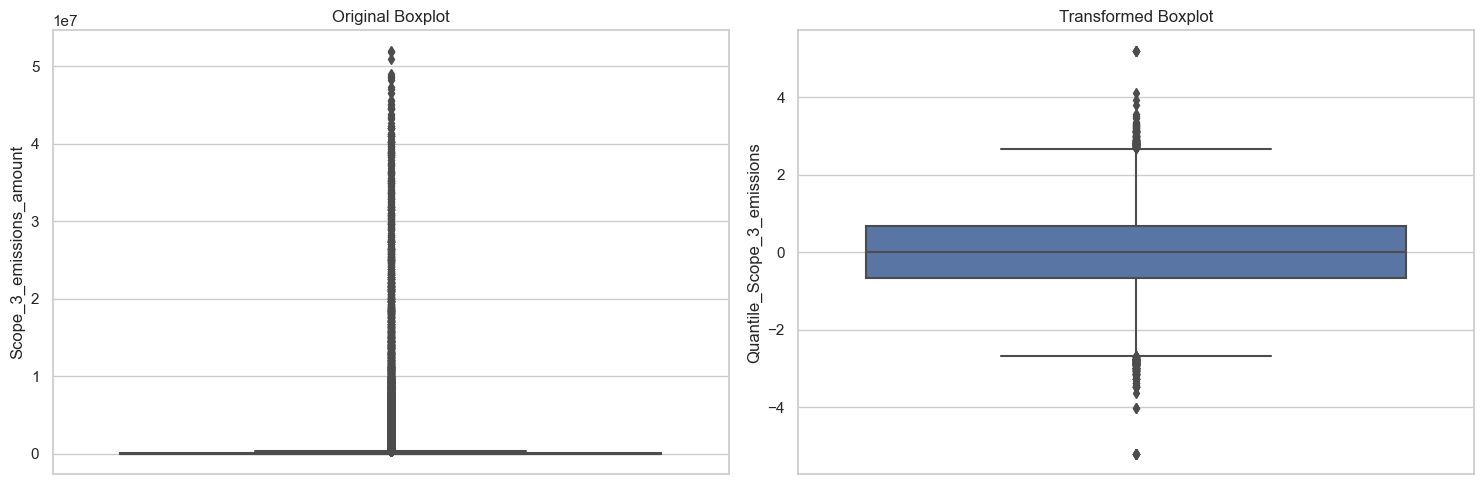


Original Data Statistics:
Skewness: 8.026
Kurtosis: 77.535
Shapiro-Wilk test (normality): statistic=0.228, p-value=0.000e+00

Transformed Data Statistics:
Skewness: -0.044
Kurtosis: 0.145
Shapiro-Wilk test (normality): statistic=0.999, p-value=4.856e-12

Descriptive Statistics:

Original Data:
count      44079.00
mean      754120.58
std      3302482.16
min            0.00
25%         2313.00
50%        18800.00
75%       159001.00
max     51997989.00
Name: Scope_3_emissions_amount, dtype: float64

Transformed Data:
count   44079.00
mean        0.00
std         1.00
min        -5.20
25%        -0.66
50%         0.00
75%         0.68
max         5.20
Name: Quantile_Scope_3_emissions, dtype: float64


In [24]:
from sklearn.preprocessing import QuantileTransformer

# Apply QuantileTransformer using normal distribution
qt = QuantileTransformer(output_distribution='normal', random_state=None)
transformed_data = qt.fit_transform(df[['Scope_3_emissions_amount']])
df['Quantile_Scope_3_emissions'] = transformed_data

# Calculate statistics for transformed data
transformed_skew = stats.skew(df['Quantile_Scope_3_emissions'])
transformed_kurtosis = stats.kurtosis(df['Quantile_Scope_3_emissions'])
transformed_shapiro = stats.shapiro(df['Quantile_Scope_3_emissions'])

# Visualize the transformation with QQ plots as insets and KDE curves on histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution with QQ plot inset
sns.histplot(data=df, x='Scope_3_emissions_amount', ax=ax1, kde=True)
ax1.set_title('Original Distribution')
ax1.set_xlabel('Original Values')

# Add QQ plot as inset for original data
ax1_inset = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Scope_3_emissions_amount'], dist="norm", plot=ax1_inset)
ax1_inset.set_title('')

# Transformed distribution with QQ plot inset
sns.histplot(data=df, x='Quantile_Scope_3_emissions', ax=ax2, kde=True)
ax2.set_title('After QuantileTransformer (Normal)')
ax2.set_xlabel('Transformed Values')

# Add QQ plot as inset for transformed data
ax2_inset = ax2.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Quantile_Scope_3_emissions'], dist="norm", plot=ax2_inset)
ax2_inset.set_title('')

plt.tight_layout()
plt.show()

# Boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, y='Scope_3_emissions_amount', ax=ax1)
ax1.set_title('Original Boxplot')

sns.boxplot(data=df, y='Quantile_Scope_3_emissions', ax=ax2)
ax2.set_title('Transformed Boxplot')

plt.tight_layout()
plt.show()

# Print statistical tests and metrics
print("\nOriginal Data Statistics:")
print(f"Skewness: {original_skew:.3f}")
print(f"Kurtosis: {original_kurtosis:.3f}")
print(f"Shapiro-Wilk test (normality): statistic={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3e}")

print("\nTransformed Data Statistics:")
print(f"Skewness: {transformed_skew:.3f}")
print(f"Kurtosis: {transformed_kurtosis:.3f}")
print(f"Shapiro-Wilk test (normality): statistic={transformed_shapiro[0]:.3f}, p-value={transformed_shapiro[1]:.3e}")

# Print summary statistics
print("\nDescriptive Statistics:")
print("\nOriginal Data:")
print(df['Scope_3_emissions_amount'].describe())
print("\nTransformed Data:")
print(df['Quantile_Scope_3_emissions'].describe())

### Box Cox

/Users/julieanne/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


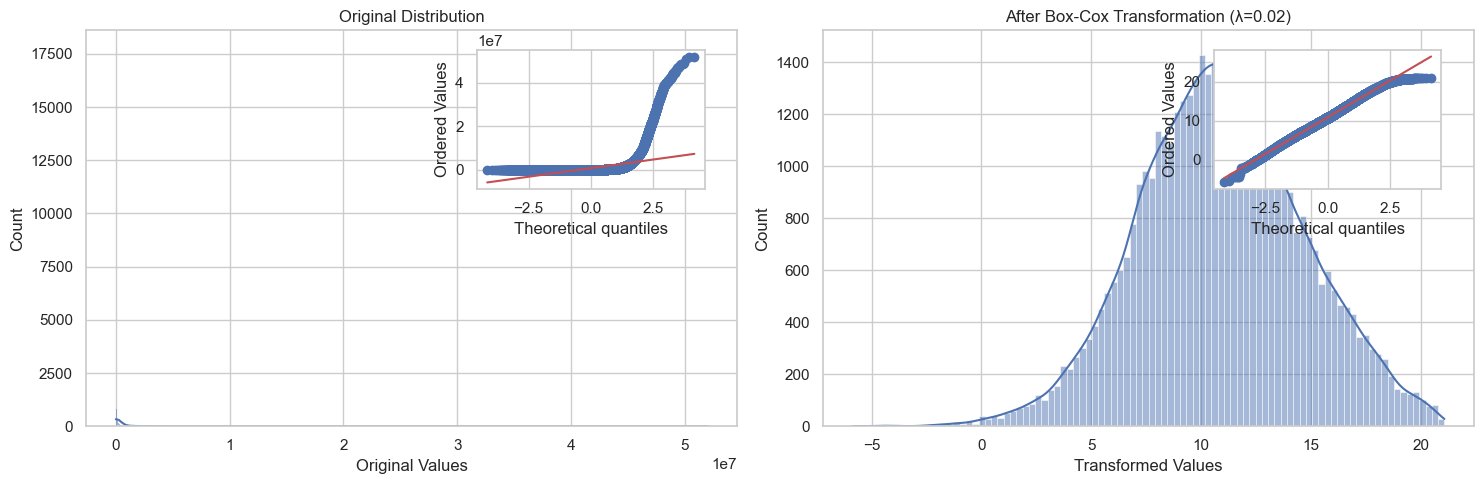

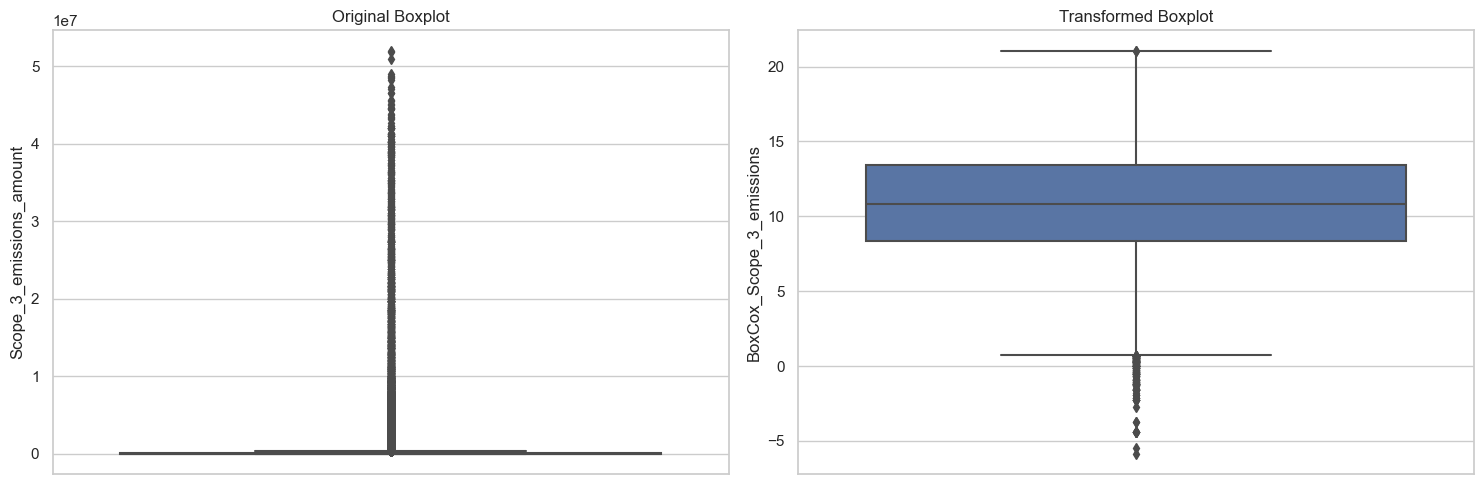


Original Data Statistics:
Skewness: 8.026
Kurtosis: 77.535
Shapiro-Wilk test (normality): statistic=0.228, p-value=0.000e+00

Transformed Data Statistics:
Skewness: -0.001
Kurtosis: -0.060
Shapiro-Wilk test (normality): statistic=0.998, p-value=1.457e-20

Descriptive Statistics:

Original Data:
count      44079.00
mean      754120.58
std      3302482.16
min            0.00
25%         2313.00
50%        18800.00
75%       159001.00
max     51997989.00
Name: Scope_3_emissions_amount, dtype: float64

Transformed Data:
count   44079.00
mean       10.90
std         3.77
min        -5.87
25%         8.34
50%        10.81
75%        13.42
max        21.07
Name: BoxCox_Scope_3_emissions, dtype: float64


In [26]:
# Apply Box-Cox transformation
transformed_data, lambda_param = stats.boxcox(df['Scope_3_emissions_amount'])
df['BoxCox_Scope_3_emissions'] = transformed_data

# Calculate statistics for transformed data
transformed_skew = stats.skew(df['BoxCox_Scope_3_emissions'])
transformed_kurtosis = stats.kurtosis(df['BoxCox_Scope_3_emissions'])
transformed_shapiro = stats.shapiro(df['BoxCox_Scope_3_emissions'])

# Visualize the transformation with QQ plots as insets and KDE curves on histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution with QQ plot inset
sns.histplot(data=df, x='Scope_3_emissions_amount', ax=ax1, kde=True)
ax1.set_title('Original Distribution')
ax1.set_xlabel('Original Values')

# Add QQ plot as inset for original data
ax1_inset = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['Scope_3_emissions_amount'], dist="norm", plot=ax1_inset)
ax1_inset.set_title('')

# Transformed distribution with QQ plot inset
sns.histplot(data=df, x='BoxCox_Scope_3_emissions', ax=ax2, kde=True)
ax2.set_title(f'After Box-Cox Transformation (λ={lambda_param:.2f})')
ax2.set_xlabel('Transformed Values')

# Add QQ plot as inset for transformed data
ax2_inset = ax2.inset_axes([0.6, 0.6, 0.35, 0.35])
stats.probplot(df['BoxCox_Scope_3_emissions'], dist="norm", plot=ax2_inset)
ax2_inset.set_title('')

plt.tight_layout()
plt.show()

# Boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, y='Scope_3_emissions_amount', ax=ax1)
ax1.set_title('Original Boxplot')

sns.boxplot(data=df, y='BoxCox_Scope_3_emissions', ax=ax2)
ax2.set_title('Transformed Boxplot')

plt.tight_layout()
plt.show()

# Print statistical tests and metrics
print("\nOriginal Data Statistics:")
print(f"Skewness: {original_skew:.3f}")
print(f"Kurtosis: {original_kurtosis:.3f}")
print(f"Shapiro-Wilk test (normality): statistic={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3e}")

print("\nTransformed Data Statistics:")
print(f"Skewness: {transformed_skew:.3f}")
print(f"Kurtosis: {transformed_kurtosis:.3f}")
print(f"Shapiro-Wilk test (normality): statistic={transformed_shapiro[0]:.3f}, p-value={transformed_shapiro[1]:.3e}")

# Print summary statistics
print("\nDescriptive Statistics:")
print("\nOriginal Data:")
print(df['Scope_3_emissions_amount'].describe())
print("\nTransformed Data:")
print(df['BoxCox_Scope_3_emissions'].describe())

### RobustScaler
Because this transformation does not change the distribution or skew, but is robust to outliers, it requires a different type of analysis to understand the impact of transformation.

/Users/julieanne/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/julieanne/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


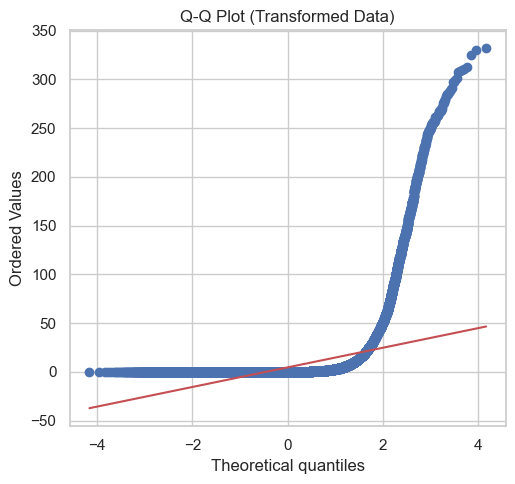


1. Basic Statistics Comparison:
Metric                 Original     Transformed          Change
------------------------------------------------------------
mean                 754120.580           4.693     -754115.887
median                18800.000           0.000      -18800.000
std                 3302444.695          21.077    -3302423.618
iqr                  156688.000           1.000     -156687.000
range              51997988.998         331.857   -51997657.141
skew                      8.026           8.026           0.000
kurtosis                 77.535          77.535           0.000

2. Scale Information:
RobustScaler center (median): 18800.000
RobustScaler scale (IQR): 156688.000

3. Transformation Findings:
- Distribution Shape: Maintained
- Central Tendency: Not centered


In [28]:
from sklearn.preprocessing import RobustScaler
from matplotlib import gridspec

# Calculate detailed statistics for original data
original_stats = {
    'skew': stats.skew(df['Scope_3_emissions_amount']),
    'kurtosis': stats.kurtosis(df['Scope_3_emissions_amount']),
    'shapiro': stats.shapiro(df['Scope_3_emissions_amount']),
    'iqr': np.percentile(df['Scope_3_emissions_amount'], 75) - np.percentile(df['Scope_3_emissions_amount'], 25),
    'median': np.median(df['Scope_3_emissions_amount']),
    'mean': np.mean(df['Scope_3_emissions_amount']),
    'std': np.std(df['Scope_3_emissions_amount']),
    'range': np.ptp(df['Scope_3_emissions_amount'])
}

# Apply RobustScaler
scaler = RobustScaler()
transformed_data = scaler.fit_transform(df[['Scope_3_emissions_amount']])
df['Robust_Scope_3_emissions'] = transformed_data

# Calculate detailed statistics for transformed data
transformed_stats = {
    'skew': stats.skew(df['Robust_Scope_3_emissions']),
    'kurtosis': stats.kurtosis(df['Robust_Scope_3_emissions']),
    'shapiro': stats.shapiro(df['Robust_Scope_3_emissions']),
    'iqr': np.percentile(df['Robust_Scope_3_emissions'], 75) - np.percentile(df['Robust_Scope_3_emissions'], 25),
    'median': np.median(df['Robust_Scope_3_emissions']),
    'mean': np.mean(df['Robust_Scope_3_emissions']),
    'std': np.std(df['Robust_Scope_3_emissions']),
    'range': np.ptp(df['Robust_Scope_3_emissions'])
}

# QQ plot of transformed data
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)
ax3 = fig.add_subplot(gs[0, 2])
stats.probplot(df['Robust_Scope_3_emissions'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Transformed Data)')
plt.tight_layout()
plt.show()

# Print analysis
print("\n1. Basic Statistics Comparison:")
print(f"{'Metric':<15} {'Original':>15} {'Transformed':>15} {'Change':>15}")
print("-" * 60)
metrics = ['mean', 'median', 'std', 'iqr', 'range', 'skew', 'kurtosis']
for metric in metrics:
    orig = original_stats[metric]
    trans = transformed_stats[metric]
    if isinstance(orig, (int, float)):
        print(f"{metric:<15} {orig:>15.3f} {trans:>15.3f} {trans-orig:>15.3f}")

print("\n2. Scale Information:")
print(f"RobustScaler center (median): {scaler.center_[0]:.3f}")
print(f"RobustScaler scale (IQR): {scaler.scale_[0]:.3f}")

print("\n3. Transformation Findings:")
print("- Distribution Shape:", "Maintained" if abs(original_stats['skew'] - transformed_stats['skew']) < 0.1 else "Modified")
print("- Central Tendency:", "Centered around zero" if abs(transformed_stats['mean']) < 0.1 else "Not centered")

### Analysis
The statistical tests and vizualizations help determine if the transformation significantly improved the normality of the data:
- Shapiro-Wilk test: p-value > 0.05 suggests normal distribution
- Skewness closer to 0 indicates more symmetric distribution
- Kurtosis closer to 0 indicates more normal-like tails
- Change in IQR ratio indicates outlier impact
- Preservation of distribution shape (skewness comparison)
- Centering effect (mean and median near zero)
- Scale standardization (standard deviation and IQR)

The quantile and box cox transformations vastly improved the skew and distribution of the data, so I can test these new values in a machine learning model against the original values.

For the RobustScaler, the IQR ratio changed dramatically, so this could indicate an overall improvement without affecting the true distribution of the data, though it is still not centered and remains more sensitive to outliers. 

In [30]:
# verify df has all transformed columns
df.columns.unique()

Index(['account_name', 'account_id', 'Year', 'incorporated_country',
       'Primary activity', 'Primary sector', 'Market_Cap_USD',
       'Third_party_verification', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_type',
       'Scope_3_emissions_amount', 'country_ghg_avg', 'country_population_avg',
       'country_gdp_avg', 'Quantile_Scope_3_emissions',
       'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions'],
      dtype='object')

For the final data, rather than having a dgp, total GHG, and Population for each year, I am going to create an average so each country has a consistent value for these features.

### Export Data

In [35]:
# Export to csv
df.to_csv('Final_GHG_Data.csv', index=False)

In [36]:
# compressed csv
df.to_csv('Final_GHG_Data.csv.gz', compression='gzip', index=False)